In [12]:
import os
import numpy as np
from spectral import *
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pickle
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

DATASTORE = 'D:\\TCC\\Datasets\\bacterias_new'
SAVESTORE = 'D:\\TCC\\Datasets\\preprocess_bac_new'
spectral.settings.envi_support_nonlowercase_params = True

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [17]:
from sklearn.cluster import KMeans
from math import factorial
from scipy.signal import savgol_filter
import pickle

def get_fewer_lines(mat, ammount):
    n_mat = []
    r, _, _ = mat.shape
    for i in range(0, r, int(r/ammount)):
        n_mat.append(mat[i, :, :])
    return np.array(n_mat)

def calibration(I, W, D):
    row,column,wave = I.shape
    arr = np.copy(I)

    meanw = np.mean(W, axis=0)
    meand = np.mean(D, axis=0)

    for z in range(wave):
        if (z % 30 == 0):
            print('CAMADAS {}-{}'.format(z, 256 if z+30>256 else z+30))
        for x in range(row):
            for y in range(column):
                w = meanw[0,y,z]
                d = meand[0,y,z]
                s = I[x,y,z]

                den = w-d
                num = s-d
                if den and num/den > 0:
                    arr[x,y,z] = -math.log10(num / den)
                else:
                    arr[x,y,z] = 0
    return arr

def hsi2matrix(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))

def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def pca_95(x):
    scaled_data = preprocessing.scale(x)

    return PCA(n_components=0.95).fit_transform(scaled_data)

def get_clusters(x):
    pca_data = pca_95(x)
    km = KMeans(n_clusters=2).fit(pca_data)
    return km

def get_layer(hsi, layer):
    return hsi[:,:,layer]


def savitzky_golay_filter(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size - 1) // 2
    b = np.mat([[k**i for i in order_range]
               for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

def snv_filter(mat):
    nmat = np.copy(mat)
    mean = np.mean(mat, axis=1)
    std = np.std(mat, axis=1)
    for i in range(mat.shape[0]):
        nmat[i] = (nmat[i] - mean[i])/std[i]
    return nmat

def remove_pixels(cube, side, amount):
    cpy_cube = np.copy(cube)
    if side == 'top':
        cpy_cube[0:amount,:,:]=0
    elif side == 'left':
        cpy_cube[:, 0:amount, :] = 0
    elif side == 'right':
        cpy_cube[:,-amount:,:]=0
    else:
        cpy_cube[-amount:, :, :] = 0
    return cpy_cube


def remove_pixels_from_all_dir(cube, ammount_top, ammount_left, ammount_right, ammount_down):
    cpy_cube = np.copy(cube)
    if ammount_top != 0:
        cpy_cube = remove_pixels(cpy_cube, 'top', ammount_top)
    if ammount_left != 0:
        cpy_cube = remove_pixels(cpy_cube, 'left', ammount_left)
    if ammount_right != 0:
        cpy_cube = remove_pixels(cpy_cube, 'right', ammount_right)
    if ammount_down != 0:
        cpy_cube = remove_pixels(cpy_cube, 'down', ammount_down)
    return cpy_cube

def apply_mask(km,mat):
    mask1 = np.copy(mat)
    mask2 = np.copy(mat)
    lab = km.labels_
    for i in range(mat.shape[0]):
        if lab[i] == 0:
            mask1[i,:] = 0
        else:
            mask2[i,:] = 0
    
    return (mat2hsi(mask1, mat.shape) ,mat2hsi(mask2, mat.shape))


def hsi_remove_background(mat):
    mat_cpy = apply_filters(mat)
    km = get_clusters(mat_cpy)
    m1, m2 = apply_mask(km, mat)
    return (m1,m2)
    
def which_cluster_to_mantain(mask1, mask2):
    plt.figure()
    plt.title("FIGURE 1")
    plt.imshow(get_layer(mask1,10), cmap='gray')
    plt.figure()
    plt.title("FIGURE 2")
    plt.imshow(get_layer(mask2, 10), cmap='gray')
    plt.show()
    
    resp = int(input('Qual cluster deseja manter? (1/2)'))
    if resp != 1 and resp != 2:
        raise BaseException("Selected option not available.")
    
    return resp - 1
    
def get_hsi_data(path):
    orig_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' not in a and 'WHITE' not in a]
    dark_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' in a]
    white_name = [a for a in os.listdir(path) if '.hdr' in a and 'WHITE' in a]

    I = open_image(os.path.join(path, orig_name[0]))
    W = open_image(os.path.join(path, white_name[0]))
    D = open_image(os.path.join(path, dark_name[0]))

    return (I.load(), W.load(), D.load())

def get_no_background_pixels(mat):
    return np.where(mat != 0)

def apply_filters(mat):
    mat_cpy = np.copy(mat)
    for i in range(mat.shape[0]):
        mat_cpy[i] = savgol_filter(mat_cpy[i], 21, 2, 1)
        # mat_cpy[i] = savgol_filter(mat_cpy[i], 25, 3, 2)

    return snv_filter(mat_cpy)


def preprocess_training_data_full(choose_bac: int, semipath: str):
    """
        choose_bac is the bacteria to process (since takes forever to do all at once)
        returns a calibrated array based on dark and white hdr's, the pixels containing the bacteria (with no background) and the label for that bacteria
    """

    bac_dirs = os.listdir(DATASTORE)

    for ind, bac in enumerate(bac_dirs):
        if (choose_bac == ind):

            individual_bac_dir = os.path.join(os.path.join(DATASTORE, bac), semipath)

            I, W, D = get_hsi_data(individual_bac_dir)

            W = get_fewer_lines(W, 25)
            D = get_fewer_lines(D, 25)

            arr_calib = calibration(I, W, D)

            cube = preprocess_training_data_from_calibration(arr_calib)
            return [arr_calib, cube]

def get_file_cube_from_folder_to_train(folder, bac_index, filename = 'calib.pickle'):
    bacs = os.path.join(SAVESTORE, folder)
    for i, bac in enumerate(os.listdir(bacs)):
        if i == bac_index:
            ind_bac_dir = os.path.join(bacs, bac)
            calib = load_pickle(filename, ind_bac_dir)
            return calib

def preprocess_training_data_from_calibration(arr_calib):
    cube = replace_median(arr_calib)

    mat = hsi2matrix(cube)

    mask1, mask2 = hsi_remove_background(mat)
    mask1 = mat2hsi(mask1, arr_calib.shape)
    mask2 = mat2hsi(mask2, arr_calib.shape)

    cluster = which_cluster_to_mantain(mask1, mask2)
    retCube = mask1
    if cluster == 1:
        retCube = mask2

    tt = hsi2matrix(retCube)
    tt = tt - np.mean(tt)

    return retCube[:, :, 1:256-14]

def replace_median(cube):
    x,y,z = cube.shape
    for i in range(z):
        rows, cols = np.where(cube[:,:,i] == 0)
        for j in range(len(rows)):
            if rows[j] > 1 and cols[j] > 1 and rows[j] < x - 1 and cols[j] < y - 1:
                wdn = cube[rows[j]-1:rows[j]+2, cols[j]-1: cols[j]+2, i]
                r, _ = np.where(wdn == 0)
                if len(r) == 1:
                    wdn = np.where(wdn != 0)
                    cube[rows[j], cols[j], i] = np.median(wdn)
    return cube

def remove_mean_of_spectre(mat):
    return mat - np.mean(mat)

################################ HELPERS #######################################

def save_pickle(path, filename, p):
    pickle_out = open(os.path.join(path, filename), "wb")
    pickle.dump(p, pickle_out)
    pickle_out.close()

def save_all(path, calib, masked):
    try:
        os.makedirs(path)
    except:
        print("Skipped - Directory already created!")

    save_pickle(path, 'calib.pickle', calib)
    save_pickle(path, 'masked.pickle', masked)

def load_pickle(filename, dirpath):
    path = os.path.join(dirpath, filename)
    pickle_in = open(path, "rb")
    return pickle.load(pickle_in)

def plot_dif_with_ref_cube(cube, ref):

    nn = hsi2matrix(cube)
    NN = hsi2matrix(ref)
    minline = min(nn.shape[0], NN.shape[0])
    nn = nn[:minline,:]
    NN = NN[:minline,:]

    nn = nn - np.mean(nn)
    NN = NN - np.mean(NN)
    
    med1 = np.mean(nn, axis=0)
    med2 = np.mean(NN, axis=0)

    print('RMSE: ', math.sqrt(np.mean(np.square(NN - nn))), 'Mean: ', np.mean(nn) - np.mean(NN))

    x = np.linspace(0, 241, 241)
    plt.plot(x, med1, '-g', label='cube1')
    plt.plot(x, med2, '-b', label='cube2')
    plt.legend()
    plt.figure()

def get_cube_by_index(path, index, filename):
    bac = os.listdir(path)[index]
    bac_dir = os.path.join(path, bac)
    return load_pickle(filename, bac_dir)
    

def get_dir_name(path, index):
    return os.listdir(path)[index]

def show_img_on_wave(cube, layer):
    mat = get_layer(cube, layer)
    plt.imshow(mat, cmap='gray')
    plt.show()

def plot_cube_spectre(cube):
    mat = hsi2matrix(cube)
    nn = np.mean(mat, axis=0)
    x = np.linspace(915, 2419, cube.shape[2])
    plt.xlabel("Comprimento de onda (nm)")
    plt.ylabel("Pseudo-absortância")
    plt.plot(x,nn)


In [23]:
testpath = os.path.join(SAVESTORE, 'Test')
for i in range(16):
    mask = get_cube_by_index(testpath, 0, 'masked.pickle')
    mat = hsi2matrix(mask)
    mat = remove_mean_of_spectre(mat)
    mask1 = mat2hsi(mat, mask.shape)
    bac_name = get_dir_name(testpath, i)
    save_pickle(os.path.join(testpath, bac_name), 'masked_v2.pickle', mask1)


Bacillusscereus_14579_Plastico_A_180926-092121
RMSE:  0.8488500600158343 Mean:  1.7473633e-06
Bacillussubtilis_6633_Plastico_A_180926-092549
RMSE:  0.7015281133571841 Mean:  1.8887777e-06
Coryniumbacteriumglutaminum_13032_Plastico_A_180926-092937
RMSE:  0.8980826962674551 Mean:  1.3282831e-06
Enterobacteaerogenes_13048_Plastico_A_Contaminado_180926-102646
RMSE:  0.9577366000746386 Mean:  -2.3158245e-06
Enterobactercloacal_HMFFTA_Plastico_A_180926-102932
RMSE:  0.9593630662604554 Mean:  -3.6889855e-06
Enterococcusfaecalis_29212_Plastico_A_180926-093825
RMSE:  1.024780615147073 Mean:  -3.6269e-08
Escherichiacoli_25922_Plastico_A_180926-101939
RMSE:  0.724711161659395 Mean:  -2.0215425e-06
Klebsielapneumonial_700603_Plastico_A_180926-105810
RMSE:  0.9232244152136346 Mean:  -1.91672e-06
Micrococcusluteus_9341_Plastico_A_180926-093421
RMSE:  0.7701020036361976 Mean:  2.1239866e-06
Proteusmirabilis_9433_Plastico_A_180926-103212
RMSE:  0.9366602633609213 Mean:  -1.5306078e-06
Pseudomonasaeoru

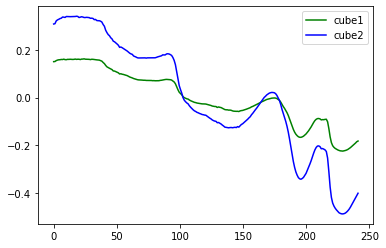

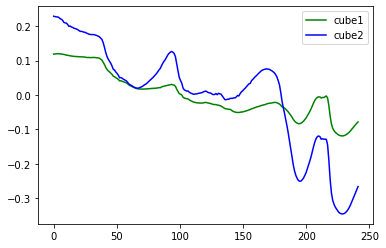

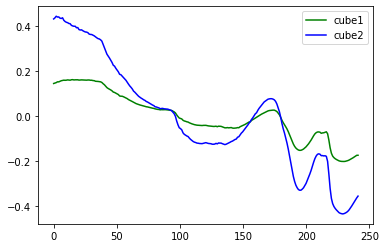

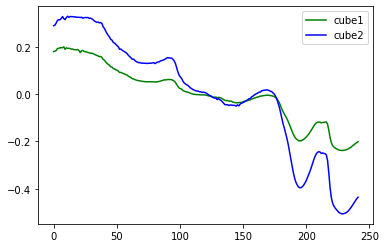

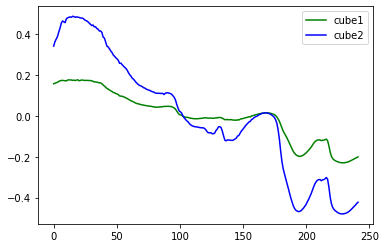

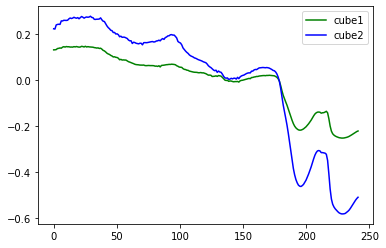

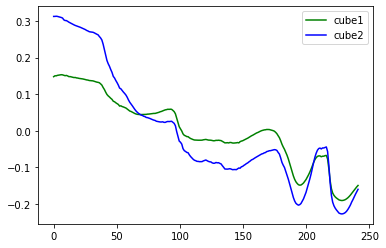

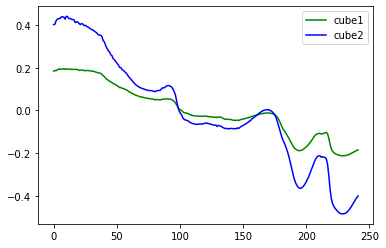

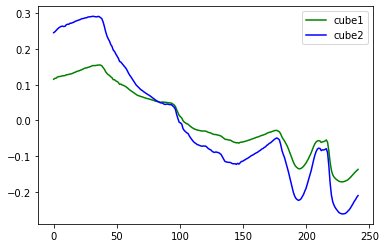

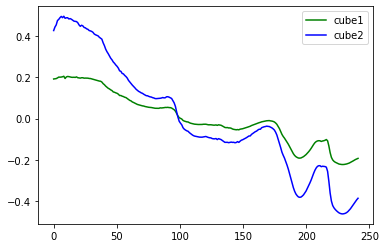

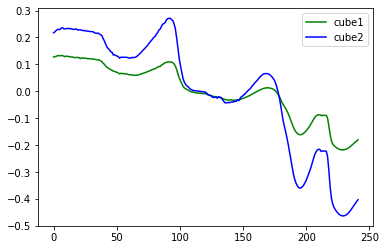

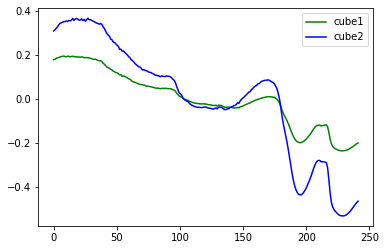

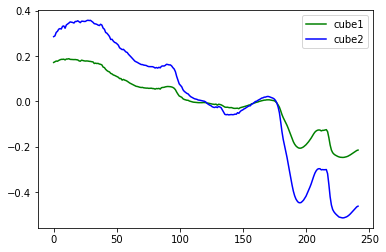

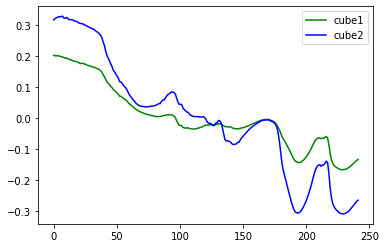

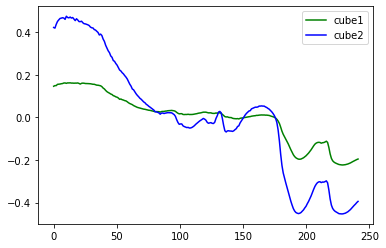

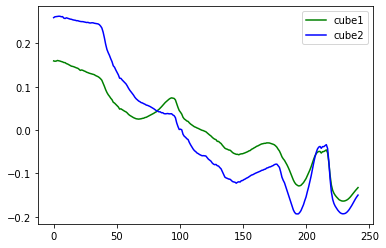

<Figure size 432x288 with 0 Axes>

In [14]:
trainpath = os.path.join(SAVESTORE, 'Train')
testpath = os.path.join(SAVESTORE, 'Test')

for i in range(16):
    print(get_dir_name(trainpath, i))
    trainCube = get_cube_by_index(trainpath, i)
    testCube = get_cube_by_index(testpath, i)

    plot_dif_with_ref_cube(trainCube, testCube)

In [24]:
trainpath = os.path.join(SAVESTORE, 'Train')
testpath = os.path.join(SAVESTORE, 'Test')
filename = 'masked_v2.pickle'

for i in range(16):
    print(get_dir_name(trainpath, i))
    trainCube = get_cube_by_index(trainpath, i, filename)
    testCube = get_cube_by_index(testpath, i, filename)

    plot_dif_with_ref_cube(trainCube, testCube)


TypeError: get_cube_by_index() missing 1 required positional argument: 'filename'